In [1]:
%cd ..

D:\Study\ml4se\code-transformer


## explore quality ~ method length

In [17]:
from ast import literal_eval
import os
import pandas as pd
import csv
from sklearn.metrics import ndcg_score
from scipy.stats import spearmanr
import numpy as np
import matplotlib.pyplot as plt

In [20]:
LANG_BINS = [6, 4, 3, 5]
MAX_TOKENS = 512

In [7]:
results_dir = 'experiments_results'
res_file = os.path.join(results_dir, 'summary.csv')

In [11]:
def divide_into_bins(data, bins):
    min_size = len(data) // bins
    min_size = int(min_size * 0.95)
    bin_num = 0
    out_ids = []
    bounds = []
    cur_n = 0
    for i in range(len(data)):
        if (bin_num != bins - 1 and i != 0 and 
            cur_n >= min_size and data[i] != data[i-1]):
            bin_num += 1
            bounds.append(data[i])
            cur_n = 0
            
        out_ids.append(bin_num)
        cur_n += 1
    return out_ids, bounds

In [12]:
def get_macro_scores(tps, fps, fns):
    recalls = []
    precisions = []
    f1s = []
    for tp, fp, fn in zip(tps, fps, fns):
        if tp+fn > 0:
            recall = tp / (tp+fn)
        else:
            recall = 0
        recalls.append(recall)
        if tp+fp > 0:
            precision = tp / (tp+fp)
        else:
            precision = 0    
        precisions.append(precision)
        if precision + recall > 0:
            f1 = 2 * precision * recall / (precision + recall)
        else:
            f1 = 0
        f1s.append(f1)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    f1s = np.array(f1s)
    
    return precisions.mean(), precisions.std(), \
            recalls.mean(), recalls.std(), \
            f1s.mean(), f1s.std()


def get_micro_scores(tps, fps, fns):
    tp = sum(tps)
    fp = sum(fps)
    fn = sum(fns)
    precision = tp / (tp+fp) if (tp+fp) > 0 else 0
    recall = tp / (tp+fn) if (tp+fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
    return precision, recall, f1

In [ ]:
snapshot = 'latest'
partition = 'test'
models = [dict(model='code_transformer',    label='CT', run_ids=range(5, 9)), 
          dict(model='great',               label='GT', run_ids=range(1, 5)),
          dict(model='xl_net',              label='XL', run_ids=range(1, 5))]
csn_langs = ['python', 'javascript', 'ruby', 'go']


fields=['model','data', 'bins',
        'mean-precision', 'std-precision', 'mean-prec-rank-corr', 'mean-prec-ndcg',
        'mean-recall', 'std-recall', 'mean-rec-rank-corr', 'mean-rec-ndcg',
        'mean-f1', 'std-f1', 'mean-f1-rank-corr', 'mean-f1-ndcg',
        'macro-precision', 'macro-prec-rank-corr','macro-prec-ndcg',
        'macro-recall', 'macro-rec-rank-corr', 'macro-rec-ndcg',
        'macro-f1', 'macro-f1-rank-corr', 'macro-f1-ndcg',
        'rougeL-f', 'rougeL-f-rank-corr', 'rougeL-f-ndcg', 
        'chrf', 'chrf-rank-corr', 'chrf-ndcg']

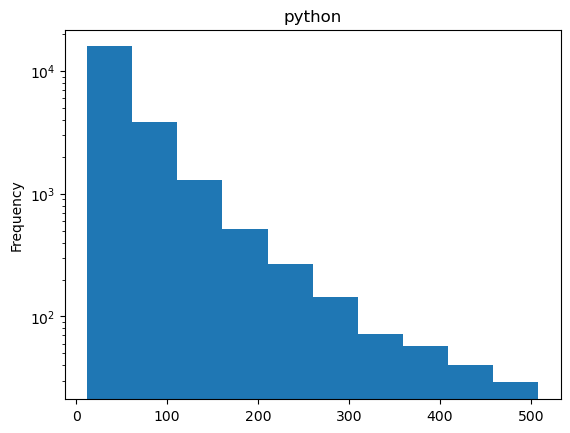

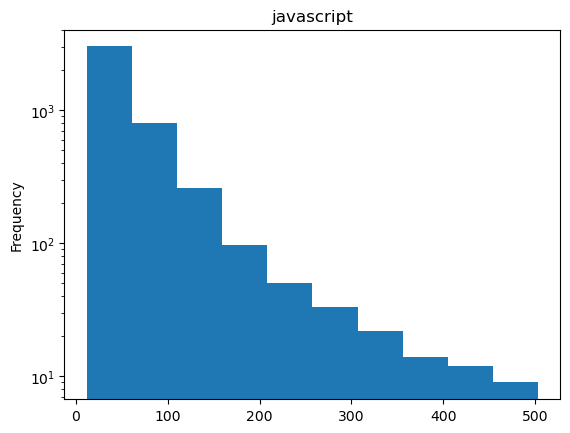

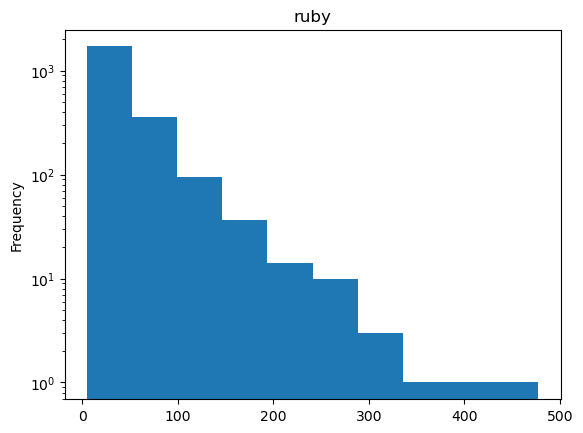

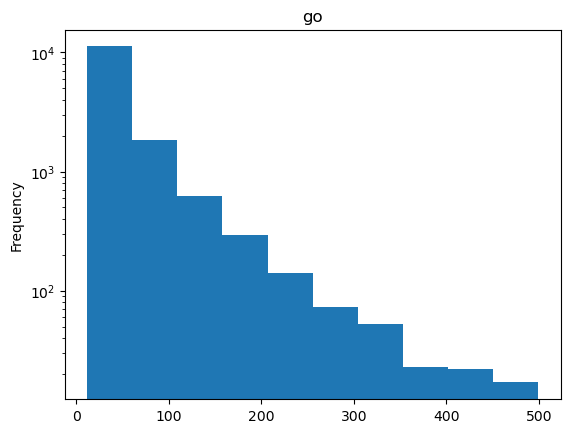

In [19]:
lang_method_lengths = []
for i in range(5, 9):
    lang = lang = csn_langs[(i - 1) % 4]
    save_path = os.path.join(results_dir, f"sample-metrics-code_transformer-{lang}-{partition}.csv")
    if not os.path.exists(save_path):
        print(f'coudnt find file {save_path}')
        continue

    metrics = pd.read_csv(save_path)
    lang_method_lengths.append(metrics.length.tolist())

    metrics.length.plot.hist(title=lang, log=True)
    plt.show()

In [21]:
with open(res_file, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(fields)

for i, model_info in enumerate(models):
    model = model_info['model']
    label = model_info['label']
    for run_id in model_info['run_ids']:
        model_id = f'{label}-{run_id}'
        lang = csn_langs[(run_id - 1) % 4]
        num_bins = LANG_BINS[(run_id - 1) % 4] 
        save_path = os.path.join(results_dir, f"sample-metrics-{model}-{lang}-{partition}.csv")
        if not os.path.exists(save_path):
            print(f'coudnt find file {save_path}')
            continue

        print(f'calculating metrics for {model} {model_id} for {lang} on {partition}...')
        
        metrics = pd.read_csv(save_path)
        metrics.sort_values('length', inplace=True)
        
        bin_ids, bounds = divide_into_bins(metrics.length.to_list(), num_bins)
        intervals = []
        for i in range(num_bins - 1):
            if i == 0:
                intervals.append(f'[0,{bounds[i]})')
            else:
                intervals.append(f'[{bounds[i-1]},{bounds[i]})')
        intervals.append(f'[{bounds[-1]},{MAX_TOKENS}]')
        print(f'splitted into bins:', ', '.join(intervals))
        
        metrics['bin'] = bin_ids
        groups = metrics.groupby('bin')
        metrics_bins = [groups.get_group(g) for g in groups.groups]
        print(f'bins sizes:', [len(metric_bin) for metric_bin in metrics_bins])
        
        pmu, pstd, rmu, rstd, fmu, fstd = map(list, zip(*[get_macro_scores(b.tp.tolist(), 
                                                                 b.fp.tolist(), 
                                                                 b.fn.tolist()) 
                                                          for b in metrics_bins]))
        prec, rec, f1 = map(list, zip(*[get_micro_scores(b.tp.tolist(), b.fp.tolist(), b.fn.tolist())
                                        for b in metrics_bins]))
        rouge1 = [b['rouge1-f'].mean() for b in metrics_bins] 
        rouge2 = [b['rouge2-f'].mean() for b in metrics_bins]
        rougel = [b['rougeL-f'].mean() for b in metrics_bins]
        chrf = [b['chrf'].apply(lambda s: float(s.split(' ')[-1])).mean() for b in metrics_bins]
        
        ranks = list(range(num_bins, 0, -1))
        with open(res_file, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([model, lang, ', '.join(intervals),
                             pmu, pstd, spearmanr(ranks, pmu).correlation, ndcg_score([ranks], [pmu]),
                             rmu, rstd, spearmanr(ranks, rmu).correlation, ndcg_score([ranks], [rmu]),
                             fmu, fstd, spearmanr(ranks, fmu).correlation, ndcg_score([ranks], [fmu]),
                             prec, spearmanr(ranks, prec).correlation, ndcg_score([ranks], [prec]),
                             rec, spearmanr(ranks, rec).correlation, ndcg_score([ranks], [rec]),
                             f1, spearmanr(ranks, f1).correlation, ndcg_score([ranks], [f1]),
                             rougel, spearmanr(ranks, rougel).correlation, ndcg_score([ranks], [rougel]),
                             chrf, spearmanr(ranks, chrf).correlation, ndcg_score([ranks], [chrf])])
        print('-----------------------------------------------------------------')

calculating metrics for code_transformer CT-5 for python on test...
splitted into bins: [0,21), [21,29), [29,40), [40,57), [57,92), [92,512]
bins sizes: [4019, 3800, 3720, 3595, 3501, 3445]
-----------------------------------------------------------------
calculating metrics for code_transformer CT-6 for javascript on test...
splitted into bins: [0,25), [25,39), [39,66), [66,512]
bins sizes: [1032, 1074, 1031, 1176]
-----------------------------------------------------------------
calculating metrics for code_transformer CT-7 for ruby on test...
splitted into bins: [0,24), [24,40), [40,512]
bins sizes: [712, 726, 790]
-----------------------------------------------------------------
calculating metrics for code_transformer CT-8 for go on test...
splitted into bins: [0,18), [18,22), [22,35), [35,61), [61,512]
bins sizes: [2757, 2804, 2837, 2787, 3071]
-----------------------------------------------------------------
calculating metrics for great GT-1 for python on test...
splitted into 

In [22]:
summary = pd.read_csv(res_file)

for col, dtype in summary.dtypes.items():
    if col in {'model', 'data', 'bins'}:
        continue
    if dtype == np.float64:
        summary[col] = summary[col].map(lambda x: round(x, 2))
    else:
        summary[col] = summary[col].apply(lambda x: list(map(lambda y: round(y, 2), literal_eval(x))))

In [23]:
summary[['model', 'data', 
         'mean-f1-rank-corr', 'mean-f1-ndcg', 
         'macro-f1-rank-corr', 'macro-f1-ndcg', 
         'rougeL-f-rank-corr', 'rougeL-f-ndcg', 
         'chrf-rank-corr', 'chrf-ndcg'
      
#          'mean-precision', 'std-precision','mean-prec-rank-corr', 'mean-prec-ndcg', 
#          'mean-recall', 'std-recall', 'mean-rec-rank-corr', 'mean-rec-ndcg', 
#          'mean-f1', 'std-f1', 'mean-f1-rank-corr', 'mean-f1-ndcg', 
#          'macro-precision', 'macro-prec-rank-corr', 'macro-prec-ndcg', 
#          'macro-recall', 'macro-rec-rank-corr', 'macro-rec-ndcg', 
#          'macro-f1', 'macro-f1-rank-corr', 'macro-f1-ndcg', 
#          'rougeL-f', 'rougeL-f-rank-corr', 'rougeL-f-ndcg',
#          'chrf', 'chrf-rank-corr', 'chrf-ndcg'
        ]]

,model,data,mean-f1-rank-corr,mean-f1-ndcg,macro-f1-rank-corr,macro-f1-ndcg,rougeL-f-rank-corr,rougeL-f-ndcg,chrf-rank-corr,chrf-ndcg
0,code_transformer,python,1.00,1.00,1.00,1.00,0.94,0.99,0.94,0.99
1,code_transformer,javascript,0.20,0.86,0.40,0.88,0.20,0.86,0.60,0.94
2,code_transformer,ruby,0.50,0.92,1.00,1.00,0.50,0.92,0.50,0.92
3,code_transformer,go,0.90,0.96,0.90,0.96,0.90,0.96,0.90,0.96
4,great,python,0.94,0.99,0.94,0.99,0.94,0.99,0.94,0.99
5,great,javascript,0.80,0.95,0.80,0.95,0.80,0.95,0.00,0.89
6,great,ruby,1.00,1.00,1.00,1.00,0.50,0.97,1.00,1.00
7,great,go,0.90,0.96,0.90,0.96,0.90,0.96,0.90,0.96
8,xl_net,python,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
9,xl_net,javascript,0.40,0.91,0.20,0.86,-0.40,0.84,-0.40,0.84
